In [1]:
import os
from dotenv import load_dotenv
load_dotenv()
import requests
import base64
import matplotlib.pyplot as plt
import numpy as np
from elasticsearch import Elasticsearch
from urllib import parse
import pandas as pd
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import logging
logging.basicConfig(level=logging.CRITICAL)

from code_utils.elastic import get_from_es,get_data_from_elastic,plot_graph,interfaces_evaluation
from code_utils.utils import get_year_ipbes,get_year_ipcc,aplatir

In [2]:
body = {
  "size": 0,
  "track_total_hits": True,
  "query": {
    "exists": {
      "field": "topics"
    }
  },
  "aggs": {
    "predicted_labels": {
      "terms": {
        "field": "predict_teds.label.keyword",
        "size": 10000000
      }
    }
  }
}
get_from_es(body,'scanr-publications')

{'took': 4560,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 1451506, 'relation': 'eq'},
  'max_score': None,
  'hits': []},
 'aggregations': {'predicted_labels': {'doc_count_error_upper_bound': 0,
   'sum_other_doc_count': 0,
   'buckets': [{'key': 'not_ipcc', 'doc_count': 1386002},
    {'key': 'ipcc', 'doc_count': 65504},
    {'key': 'ipcc_adaptation', 'doc_count': 43479},
    {'key': 'ipcc_science', 'doc_count': 15250},
    {'key': 'ipcc_mitigation', 'doc_count': 8819}]}}}

In [8]:
body = {
  "size": 0,
  "track_total_hits": True,
  "query": {
    "bool": {
      "must_not": [
        {
          "exists": {
            "field": "topics"
          }
        }
      ]
    }
  },
  "aggs": {
    "predicted_labels": {
      "terms": {
        "field": "predict_teds.label.keyword",
        "size": 10000000
      }
    }
  }
}
get_from_es(body,'scanr-publications')

{'took': 1331,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 4550895, 'relation': 'eq'},
  'max_score': None,
  'hits': []},
 'aggregations': {'predicted_labels': {'doc_count_error_upper_bound': 0,
   'sum_other_doc_count': 0,
   'buckets': [{'key': 'not_ipcc', 'doc_count': 4538677},
    {'key': 'ipcc', 'doc_count': 12218},
    {'key': 'ipcc_adaptation', 'doc_count': 5871},
    {'key': 'ipcc_mitigation', 'doc_count': 3285},
    {'key': 'ipcc_science', 'doc_count': 284}]}}}

In [3]:
body = {
  "size": 0, 
  "query": {
    "exists": {
      "field": "topics"
    }
  }
}

In [ ]:
body = {
  "size": 0,
  "track_total_hits": True,
  "query": {
    "exists": {
      "field": "topics"
    }
  },
  "aggs": {
    "predicted_labels": {
      "terms": {
        "field": "predict_teds.label.keyword",
        "size": 10000000
      },
      "aggs": {
        "predicted_labels": {
          "terms": {
            "field": "predict_teds.label.keyword",
            "size": 10000000
          }
        }
      }
    }
  }
}
get_from_es(body,'scanr-publications')

In [55]:
body = {
  "size": 0,
  "track_total_hits": True,
  "query": {
    "exists": {
      "field": "topics"
    }
  },
  "aggs": {
    "years": {
      "terms": {
        "field": "year",
        "size": 10000000
      },
      "aggs": {
        "predicted_labels": {
          "terms": {
            "field": "predict_teds.label.keyword",
            "size": 10000000
          }
        }
      }
    }
  }
}
get_from_es(body,'scanr-publications')

{'took': 5,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 1451506, 'relation': 'eq'},
  'max_score': None,
  'hits': []},
 'aggregations': {'years': {'doc_count_error_upper_bound': 0,
   'sum_other_doc_count': 0,
   'buckets': [{'key': 2022,
     'doc_count': 139716,
     'predicted_labels': {'doc_count_error_upper_bound': 0,
      'sum_other_doc_count': 0,
      'buckets': [{'key': 'not_ipcc', 'doc_count': 131942},
       {'key': 'ipcc', 'doc_count': 7774},
       {'key': 'ipcc_adaptation', 'doc_count': 5028},
       {'key': 'ipcc_science', 'doc_count': 1837},
       {'key': 'ipcc_mitigation', 'doc_count': 1140}]}},
    {'key': 2021,
     'doc_count': 139629,
     'predicted_labels': {'doc_count_error_upper_bound': 0,
      'sum_other_doc_count': 0,
      'buckets': [{'key': 'not_ipcc', 'doc_count': 132113},
       {'key': 'ipcc', 'doc_count': 7516},
       {'key': 'ipcc_adaptation', 'doc_count': 4928},
       {

In [56]:
data=get_from_es(body,'scanr-publications')

In [57]:
years = [x['key'] for x in data['aggregations']['years']['buckets']]
labels = ['ipcc_adaptation', 'ipcc_science', 'ipcc_mitigation']
values = {label: [] for label in labels}

In [58]:
x=data['aggregations']['years']['buckets'][0]

In [59]:
[bucket['key'] for bucket in x['predicted_labels']['buckets']]

['not_ipcc', 'ipcc', 'ipcc_adaptation', 'ipcc_science', 'ipcc_mitigation']

In [60]:
data_counts={}
for x in data['aggregations']['years']['buckets']:
    #print(x['key'])
    data_counts[x['key']]=[]#x['doc_count']]
    if 'ipcc_science' in [bucket['key'] for bucket in x['predicted_labels']['buckets']]:
        data_counts[x['key']].append([bucket['doc_count'] for bucket in x['predicted_labels']['buckets'] if bucket['key']=='ipcc_science'][0]) 
    else:
        data_counts[x['key']].append(0)
    if 'ipcc_adaptation' in [bucket['key'] for bucket in x['predicted_labels']['buckets']]:
        data_counts[x['key']].append([bucket['doc_count'] for bucket in x['predicted_labels']['buckets'] if bucket['key']=='ipcc_adaptation'][0]) 
    else:
        data_counts[x['key']].append(0)
    if 'ipcc_mitigation' in [bucket['key'] for bucket in x['predicted_labels']['buckets']]:   
        data_counts[x['key']].append([bucket['doc_count'] for bucket in x['predicted_labels']['buckets'] if bucket['key']=='ipcc_mitigation'][0]) 
    else:
        data_counts[x['key']].append(0)

In [61]:
data_counts

{2022: [1837, 5028, 1140],
 2021: [1703, 4928, 1063],
 2020: [1695, 4684, 882],
 2023: [1733, 4868, 1243],
 2019: [1288, 3949, 832],
 2018: [1249, 3894, 771],
 2017: [1068, 3325, 639],
 2016: [1120, 3217, 560],
 2014: [1076, 2912, 473],
 2015: [1045, 3033, 537],
 2013: [1130, 2656, 451],
 2024: [306, 983, 228],
 2012: [0, 1, 0],
 2011: [0, 1, 0],
 2025: [0, 0, 0],
 1970: [0, 0, 0],
 2026: [0, 0, 0],
 2009: [0, 0, 0],
 2010: [0, 0, 0],
 2033: [0, 0, 0],
 2050: [0, 0, 0],
 2103: [0, 0, 0]}

In [62]:
df = pd.DataFrame.from_dict(data_counts, orient='index', columns=['ipcc_science', 'ipcc_adaptation', 'ipcc_mitigation'])
df = df.sort_index()

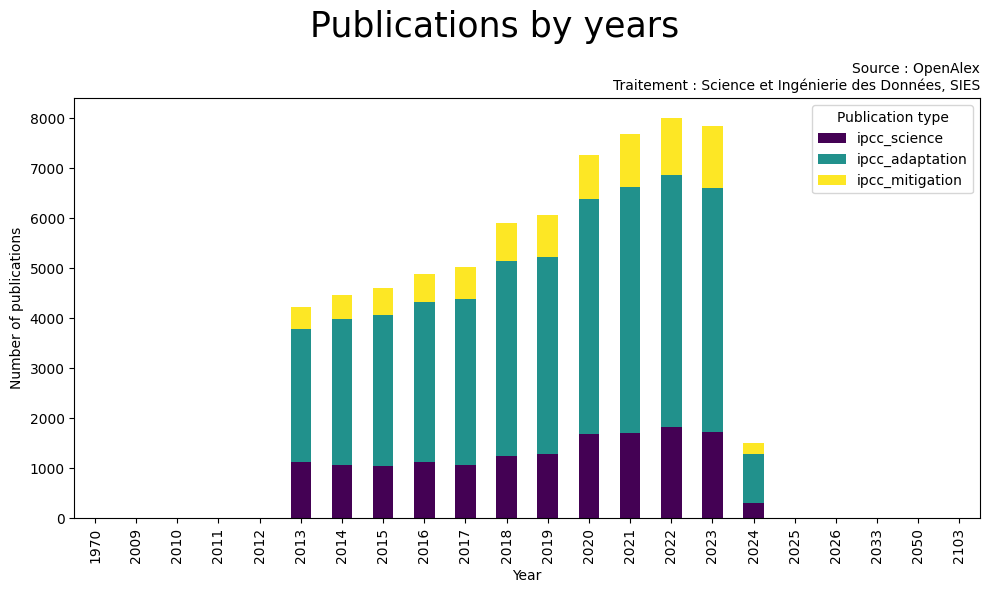

In [63]:
ax = df.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
ax.set_xlabel('Year')
ax.set_ylabel('Number of publications')
ax.legend(title='Publication type')

plt.suptitle("Publications by years", size=25)
plt.title('Source : OpenAlex\nTraitement : Science et Ingénierie des Données, SIES', size=10, loc='right')
plt.tight_layout()
plt.show()